# Импорт библиотек и настройка окружения

В этом блоке мы подключаем нужные библиотеки и проводим базовую настройку окружения. Здесь же можно установить и настроить доступ к Kaggle или Google Drive, если необходимо.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

print("TensorFlow version:", tf.__version__)

# Если нужно, можно настроить kaggle или Google Drive здесь, например:
# from google.colab import drive
# drive.mount('/content/drive')
# или
!pip install kaggle
# и т.д.

# Устанавливаем некоторый параметр для отображения графиков
plt.rcParams['figure.figsize'] = (8, 6)
sns.set_style("whitegrid")

TensorFlow version: 2.17.1


In [2]:
# Загружаем *.json-файл
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parisville","key":"e9b1f64413eb9a6e2c4463e3a125650a"}'}

In [3]:
# Создаем директорию для конфигурационного файла
!mkdir -p ~/.kaggle

# Перемещаем загруженный файл kaggle.json в созданную директорию
!cp kaggle.json ~/.kaggle/

# Устанавливаем необходимые права доступа
!chmod 600 ~/.kaggle/kaggle.json

# Проверяем, что Kaggle API настроен корректно
!kaggle datasets list

ref                                                          title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
bhadramohit/customer-shopping-latest-trends-dataset          Customer Shopping (Latest Trends) Dataset      76KB  2024-11-23 15:26:12          17655        348  1.0              
hopesb/student-depression-dataset                            Student Depression Dataset.                   454KB  2024-11-22 17:56:03          14244        194  1.0              
bushraqurban/tourism-and-economic-impact                     ✈️ Tourism and Economic Impact Dataset💰       270KB  2024-12-22 08:47:37           1054         31  1.0              
vedaantsingh/comprehensive-cryptocurrency-market-data        Comprehensive Cryptocurrency Market Data 🚀🌕 

In [4]:
# Создаем директорию для датасетов
!mkdir -p datasets

# Загружаем первый датасет
!kaggle datasets download -d imoore/6000-store-items-images-classified-by-color -p datasets

# Разархивируем загруженный датасет
!unzip -q datasets/6000-store-items-images-classified-by-color.zip -d datasets/6000_store_items

# Загружаем второй датасет
!kaggle datasets download -d ayanzadeh93/color-classification -p datasets

# Разархивируем загруженный датасет
!unzip -q datasets/color-classification.zip -d datasets/color_classification

Dataset URL: https://www.kaggle.com/datasets/imoore/6000-store-items-images-classified-by-color
License(s): other
 86% 44.0M/51.2M [00:00<00:00, 100MB/s]
100% 51.2M/51.2M [00:00<00:00, 97.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/ayanzadeh93/color-classification
License(s): ODbL-1.0
 93% 151M/161M [00:02<00:00, 91.4MB/s]
100% 161M/161M [00:02<00:00, 76.9MB/s]


[6000+ Store Items Images Classified By Color](https://www.kaggle.com/datasets/imoore/6000-store-items-images-classified-by-color): набор данных содержит более 6000 изображений, представляющих различные товары, классифицированные по их цвету. Каждый элемент датасета распределен по категориям, обозначающим основные цвета, такие как черный, синий, красный и другие. Этот датасет разработан для задач, связанных с визуальной классификацией объектов по цветовым характеристикам, и подходит для исследований в области компьютерного зрения, машинного обучения и анализа изображений. Высокое разнообразие товаров делает его полезным для обучения моделей, работающих с реальными данными в розничной торговле и e-commerce.

[Color Classification:](https://www.kaggle.com/datasets/ayanzadeh93/color-classification) этот датасет ориентирован на решение задачи классификации изображений по цвету. Он содержит изображения, которые распределены по папкам, каждая из которых соответствует определенному цвету, включая основные оттенки, такие как черный, белый, синий и коричневый. Датасет предназначен для разработки и тестирования алгоритмов классификации изображений, особенно в контексте задач сегментации и цветового анализа. Его структура упрощает процесс подготовки данных для обучения моделей и экспериментов, связанных с визуальным восприятием и распознаванием цвета.

# Загрузка данных, предобработка, визуализация

В этом блоке мы загружаем данные, задаём минимальную предобработку и строим пару изображений для визуализации. Оба датасета уже структурированы по подпапкам, где цвета – это классы.

In [5]:
import os
import shutil

# Пути к исходным папкам
source_1 = 'datasets/6000_store_items/train'
source_2 = 'datasets/color_classification/ColorClassification'
combined_path = 'datasets/combined_dataset'

# Создаем директорию для объединенного набора данных
os.makedirs(combined_path, exist_ok=True)

# Функция для копирования файлов с преобразованием названий цветов в нижний регистр
def copy_and_normalize(source, destination):
    for folder in os.listdir(source):
        folder_path = os.path.join(source, folder)
        if os.path.isdir(folder_path):
            # Приводим название папки к нижнему регистру
            normalized_folder = folder.lower()
            dest_folder = os.path.join(destination, normalized_folder)
            os.makedirs(dest_folder, exist_ok=True)

            # Копируем все файлы из исходной папки
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.isfile(file_path):
                    shutil.copy(file_path, dest_folder)

# Копируем данные из обеих исходных папок
copy_and_normalize(source_1, combined_path)
copy_and_normalize(source_2, combined_path)

print("Объединение папок завершено. Все данные приведены к единому регистру.")

Объединение папок завершено. Все данные приведены к единому регистру.


In [6]:
import os
import shutil

# Путь к объединенной директории
combined_path = 'datasets/combined_dataset'

# Список допустимых названий цветов
valid_colors = [
    'black', 'blue', 'brown', 'green', 'grey',
    'orange', 'pink', 'purple', 'red', 'silver',
    'white', 'yellow'
]

# Удаляем папки, которые не относятся к цветам
for folder in os.listdir(combined_path):
    folder_path = os.path.join(combined_path, folder)
    if os.path.isdir(folder_path) and folder.lower() not in valid_colors:
        shutil.rmtree(folder_path)
        print(f"Удалена папка: {folder_path}")

print("Формирование датасета завершено. Оставлены только папки с названиями цветов.")

Удалена папка: datasets/combined_dataset/mask_green
Удалена папка: datasets/combined_dataset/mask_blue
Удалена папка: datasets/combined_dataset/mask_brown
Удалена папка: datasets/combined_dataset/mask_black
Удалена папка: datasets/combined_dataset/mask_violet
Удалена папка: datasets/combined_dataset/color-classification
Удалена папка: datasets/combined_dataset/mask_yellow
Удалена папка: datasets/combined_dataset/mask_test
Удалена папка: datasets/combined_dataset/testimg
Удалена папка: datasets/combined_dataset/mask_red
Удалена папка: datasets/combined_dataset/violet
Удалена папка: datasets/combined_dataset/mask_white
Удалена папка: datasets/combined_dataset/mask_orange
Формирование датасета завершено. Оставлены только папки с названиями цветов.


In [7]:
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Пути к основным директориям
base_dir = 'datasets/combined_dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Удаляем старые директории, если они существуют, и создаем новые
for directory in [train_dir, val_dir, test_dir]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

# Получаем только папки с цветами, исключая скрытые системные файлы
color_classes = [folder for folder in os.listdir(base_dir)
                 if os.path.isdir(os.path.join(base_dir, folder)) and not folder.startswith('.')]

# Перераспределение данных: 70% - train, 20% - val, 10% - test
for color in color_classes:
    class_path = os.path.join(base_dir, color)
    images = [img for img in os.listdir(class_path) if not img.startswith('.') and os.path.isfile(os.path.join(class_path, img))]
    random.shuffle(images)

    # Вычисляем количество данных для каждой выборки
    num_images = len(images)
    num_train = int(num_images * 0.7)
    num_val = int(num_images * 0.2)

    # Разделяем данные
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Создаем директории для текущего класса
    os.makedirs(os.path.join(train_dir, color), exist_ok=True)
    os.makedirs(os.path.join(val_dir, color), exist_ok=True)
    os.makedirs(os.path.join(test_dir, color), exist_ok=True)

    # Перемещаем изображения
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, color, img))
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, color, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, color, img))

print("Данные успешно распределены по выборкам.")

# Параметры изображений и размер батча
IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 32

# Создаем генераторы данных
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Генератор для обучающих данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

# Генератор для валидационных данных
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

# Генератор для тестовых данных
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

# Печать классов для проверки
print("Классы в обучающих данных:", train_generator.class_indices)
print("Классы в тестовых данных:", test_generator.class_indices)

Данные успешно распределены по выборкам.
Found 4428 images belonging to 15 classes.
Found 1264 images belonging to 15 classes.
Found 644 images belonging to 15 classes.
Классы в обучающих данных: {'black': 0, 'blue': 1, 'brown': 2, 'green': 3, 'grey': 4, 'orange': 5, 'pink': 6, 'purple': 7, 'red': 8, 'silver': 9, 'test': 10, 'train': 11, 'val': 12, 'white': 13, 'yellow': 14}
Классы в тестовых данных: {'black': 0, 'blue': 1, 'brown': 2, 'green': 3, 'grey': 4, 'orange': 5, 'pink': 6, 'purple': 7, 'red': 8, 'silver': 9, 'test': 10, 'train': 11, 'val': 12, 'white': 13, 'yellow': 14}


Class indices: {'black': 0, 'blue': 1, 'brown': 2, 'green': 3, 'grey': 4, 'orange': 5, 'pink': 6, 'purple': 7, 'red': 8, 'silver': 9, 'test': 10, 'train': 11, 'val': 12, 'white': 13, 'yellow': 14}


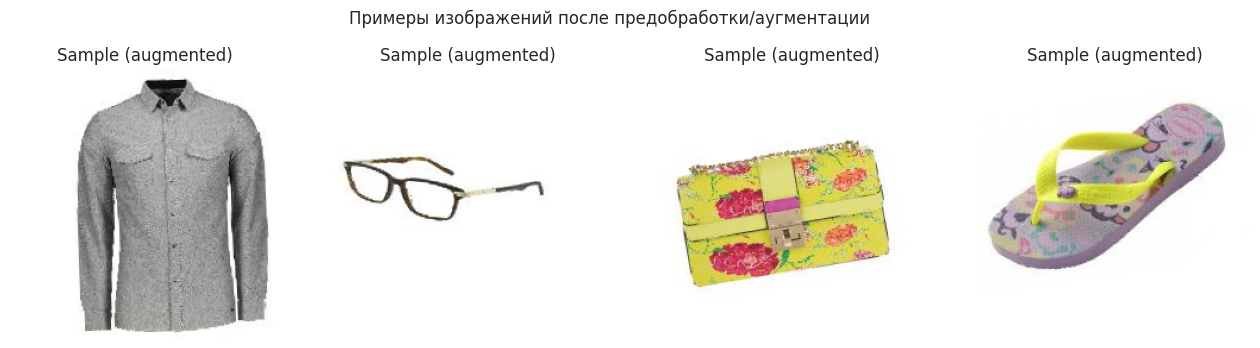

In [8]:
# Словарь классов
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Чтобы визуализировать пару изображений "до" и "после", можно получить batch из train_generator
x_batch, y_batch = next(train_generator)  # Получаем пакет (X, Y)
# x_batch у нас уже в виде float32 [0..1], но можно предположить "до" аугментации -> показать ещё raw

# Выведем первые 4 изображения
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].imshow(x_batch[i])
    axes[i].set_title("Sample (augmented)")
    axes[i].axis('off')
plt.suptitle("Примеры изображений после предобработки/аугментации")
plt.show()

# 3. Базовая (Baseline) модель

В этом блоке мы определим нашу базовую модель (Baseline): простую CNN без всяких ухищрений, чтобы потом сравнить её с остальными. После определения модели выведем её архитектуру и сохраним схему.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 225, 225, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 225, 225, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 110, 110, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 110, 110, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 55, 55, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 53, 53, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 53, 53, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      44,302,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,679,055 (170.44 MB)

 Trainable params: 44,678,159 (170.43 MB)

 Non-trainable params: 896 (3.50 KB)

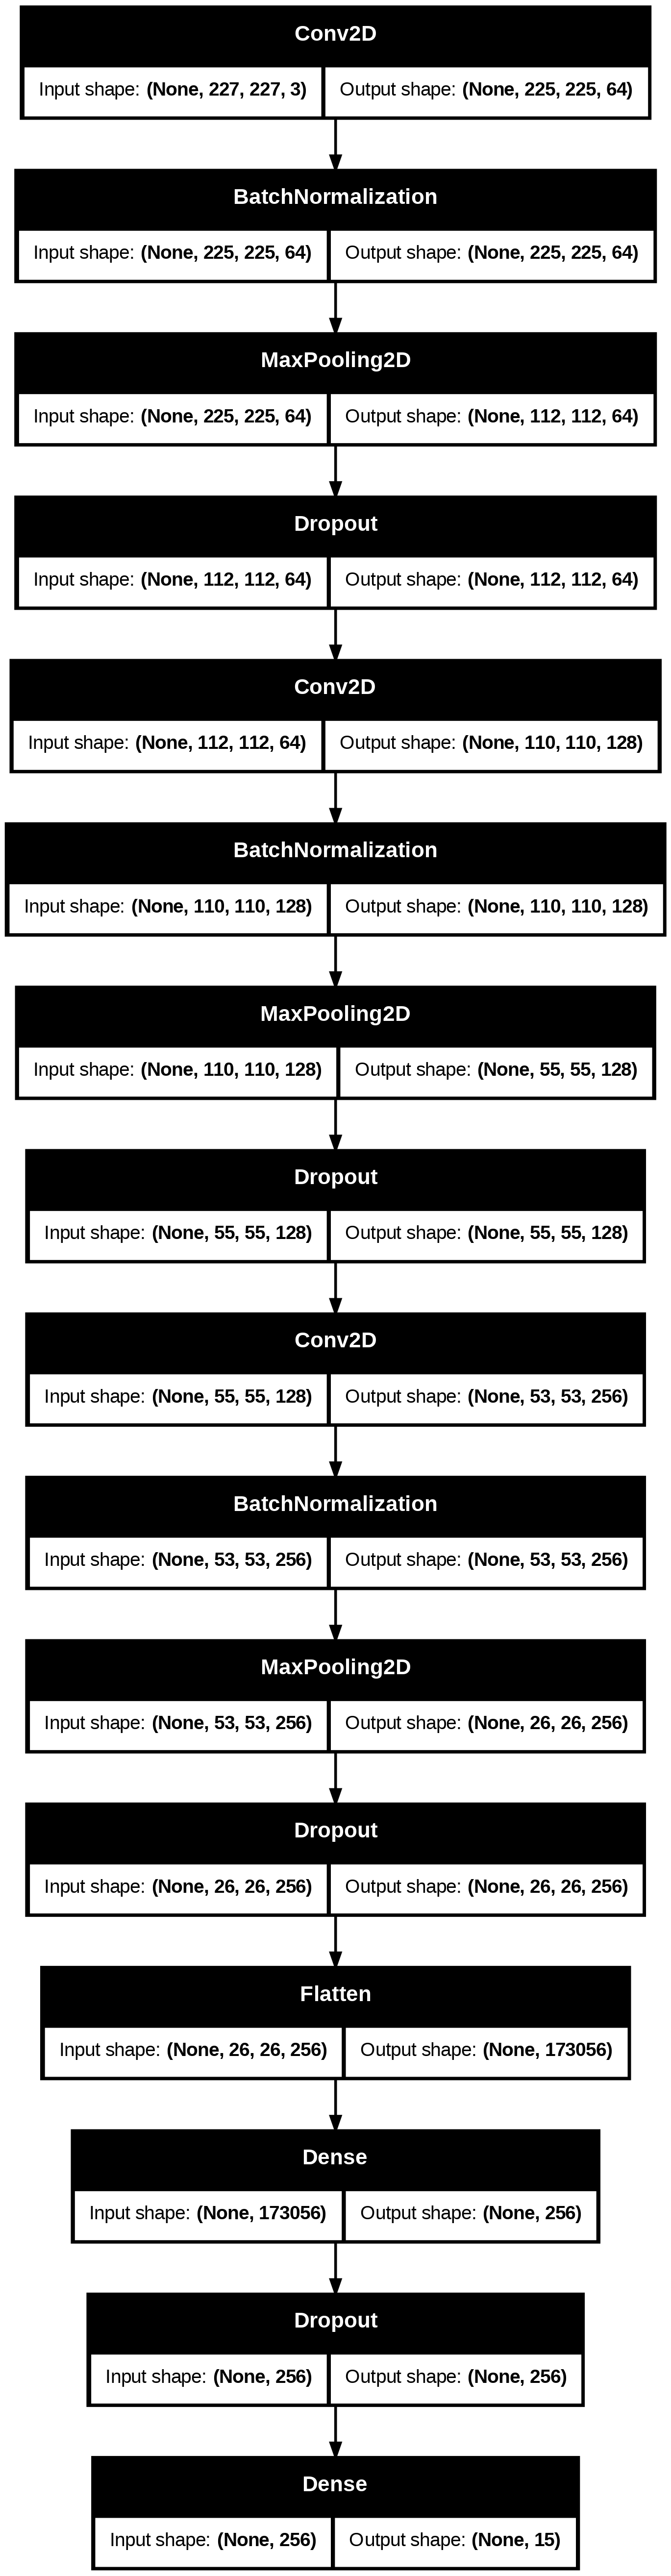

In [9]:
num_classes = len(class_indices)  # Количество классов (цветов)

# 1. Базовая модель
def create_baseline_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

baseline_model = create_baseline_model()
baseline_model.summary()
plot_model(baseline_model, to_file='baseline_model.png', show_shapes=True)

# Предобученная (Pretrained) модель MobileNetV2

В этом блоке мы определим вторую модель (Pretrained), например, на основе MobileNetV2. Включим глобальный pooling и финальные Dense-слои. Входные изображения нужно пропускать через функцию mobilenet_preprocess, поэтому создадим ещё один генератор или добавим шаг препроцессинга.

<ipython-input-10-713c3efbd562>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 227, 227, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 114, 114, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 114, 114, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 114, 114, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 114, 114, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 114, 114, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 114, 114, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 114, 114, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 114, 114, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 114, 114, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 114, 114, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 114, 114, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 115, 115, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 57, 57, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,622,287 (10.00 MB)

 Trainable params: 363,535 (1.39 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.607674 to fit



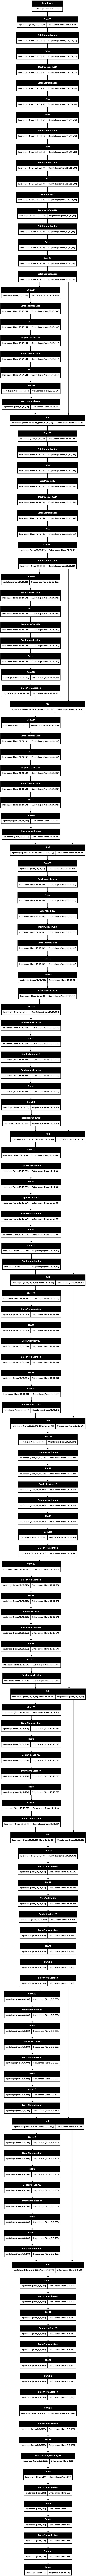

In [10]:
base_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_mobilenet.trainable = False  # Замораживаем базовые слои

def create_pretrained_model(base_model, classes=num_classes):
    # Входная модель (предобученная)
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Исправлено: корректный вызов BatchNormalization
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)  # Исправлено
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(classes, activation='softmax')(x)

    # Создаём модель
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    # Компиляция модели
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

pretrained_model = create_pretrained_model(base_mobilenet)
pretrained_model.summary()
plot_model(pretrained_model, to_file='pretrained_model.png', show_shapes=True)

# Модифицированная (Modified) модель

В этом блоке мы определим модифицированную модель (Modified). Допустим, мы добавим skip-коннекты или, например, attention-модуль или двуглавую структуру. Для наглядности сделаем нечто чуть более сложное, чем Baseline: добавим боковую ветвь и объединим. Это очень условный пример, но демонстрирует идею.

In [11]:
def create_modified_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=num_classes):
    inputs = layers.Input(shape=input_shape)

    # Основная ветвь A
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Боковая ветвь B (Skip Connection)
    y = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D((2, 2))(y)
    y = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.GlobalAveragePooling2D()(y)

    # Проверяем размерности ветвей для объединения
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)

    # Убедимся, что размеры совместимы перед объединением
    x_shape = tf.keras.backend.int_shape(x)
    y_shape = tf.keras.backend.int_shape(y)
    if len(x_shape) != len(y_shape):
        y = layers.Reshape((1,))(y)  # Приведение y к совместимой форме

    concat = layers.concatenate([x, y])

    # Несколько Dense-слоёв после concat
    fc = layers.Dense(256, activation='relu')(concat)
    fc = layers.BatchNormalization()(fc)
    fc = layers.Dropout(0.5)(fc)
    fc = layers.Dense(128, activation='relu')(fc)
    fc = layers.Dropout(0.3)(fc)
    outputs = layers.Dense(classes, activation='softmax')(fc)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

modified_model = create_modified_model()
modified_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 227, 227, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 227, 227, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 227, 227, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 113, 113, 64)   │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 113, 113, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 113, 113, 128)  │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 227, 227, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 128)    │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 227, 227, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 113, 113, 64)   │              0 │ batch_normalization_7… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 56, 56, 256)    │          1,024 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 113, 113, 128)  │         73,856 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 28, 28, 256)    │              0 │ batch_normalization_9… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 113, 113, 128)  │            512 │ conv2d_6[0][0]         │
│ (BatchNormalization) 

 Total params: 51,898,127 (197.98 MB)

 Trainable params: 51,896,335 (197.97 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
# Альтернативный способ визуализации структуры модели
for i, layer in enumerate(modified_model.layers):
    output_shape = getattr(layer, 'output_shape', 'N/A')  # Проверяем наличие атрибута
    print(f"Layer {i}: {layer.name}, Output Shape: {output_shape}")

Layer 0: input_layer_2, Output Shape: N/A
Layer 1: conv2d_3, Output Shape: N/A
Layer 2: batch_normalization_5, Output Shape: N/A
Layer 3: max_pooling2d_3, Output Shape: N/A
Layer 4: conv2d_4, Output Shape: N/A
Layer 5: batch_normalization_6, Output Shape: N/A
Layer 6: conv2d_5, Output Shape: N/A
Layer 7: max_pooling2d_4, Output Shape: N/A
Layer 8: batch_normalization_7, Output Shape: N/A
Layer 9: conv2d_7, Output Shape: N/A
Layer 10: max_pooling2d_5, Output Shape: N/A
Layer 11: batch_normalization_9, Output Shape: N/A
Layer 12: conv2d_6, Output Shape: N/A
Layer 13: max_pooling2d_6, Output Shape: N/A
Layer 14: batch_normalization_8, Output Shape: N/A
Layer 15: flatten_1, Output Shape: N/A
Layer 16: global_average_pooling2d_1, Output Shape: N/A
Layer 17: concatenate, Output Shape: N/A
Layer 18: dense_5, Output Shape: N/A
Layer 19: batch_normalization_10, Output Shape: N/A
Layer 20: dropout_6, Output Shape: N/A
Layer 21: dense_6, Output Shape: N/A
Layer 22: dropout_7, Output Shape: N/A
La

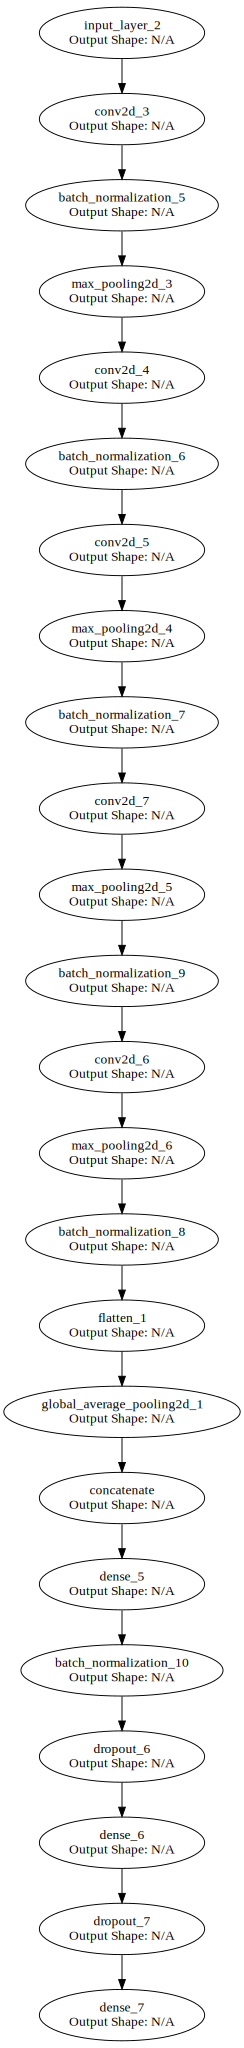

In [13]:
from graphviz import Digraph

def visualize_model_architecture(model):
    dot = Digraph(comment='Model Architecture')
    for i, layer in enumerate(model.layers):
        layer_name = layer.name
        output_shape = getattr(layer, 'output_shape', 'N/A')
        dot.node(f'Layer_{i}', f"{layer_name}\nOutput Shape: {output_shape}")
        if i > 0:
            dot.edge(f'Layer_{i-1}', f'Layer_{i}')
    dot.render('model_architecture', format='png', cleanup=True)
    return dot

# Визуализация архитектуры
visualize_model_architecture(modified_model)

# Обучение и оценка всех моделей, сбор результатов

In [15]:
EPOCHS = 20

history_dict = {}  # здесь будем хранить истории обучения
results_df = pd.DataFrame(columns=['Model', 'ValAccuracy', 'ValLoss', 'TestAccuracy', 'Precision', 'Recall', 'F1'])

# ========== Baseline ==========
baseline_model = create_baseline_model()
hist_baseline = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)
history_dict['Baseline'] = hist_baseline

# Оценим на валидации
val_loss_b, val_acc_b = baseline_model.evaluate(val_generator, verbose=0)

# Оценим на тесте
test_loss_b, test_acc_b = baseline_model.evaluate(test_generator, verbose=0)

# Предсказания для precision/recall/f1
y_pred_b = np.argmax(baseline_model.predict(test_generator), axis=1)
y_true_b = test_generator.classes
precision_b = precision_score(y_true_b, y_pred_b, average='macro')
recall_b    = recall_score(y_true_b, y_pred_b, average='macro')
f1_b        = f1_score(y_true_b, y_pred_b, average='macro')

new_row = pd.DataFrame([{
    'Model': 'Baseline',
    'ValAccuracy': val_acc_b,
    'ValLoss': val_loss_b,
    'TestAccuracy': test_acc_b,
    'Precision': precision_b,
    'Recall': recall_b,
    'F1': f1_b
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

# ========== Pretrained ==========
pretrained_model = create_pretrained_model(base_mobilenet)
hist_pretrained = pretrained_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)
history_dict['Pretrained'] = hist_pretrained

val_loss_p, val_acc_p = pretrained_model.evaluate(val_generator, verbose=0)
test_loss_p, test_acc_p = pretrained_model.evaluate(test_generator, verbose=0)

y_pred_p = np.argmax(pretrained_model.predict(test_generator), axis=1)
y_true_p = test_generator.classes
precision_p = precision_score(y_true_p, y_pred_p, average='macro')
recall_p    = recall_score(y_true_p, y_pred_p, average='macro')
f1_p        = f1_score(y_true_p, y_pred_p, average='macro')

new_row = pd.DataFrame([{
    'Model': 'Pretrained',
    'ValAccuracy': val_acc_p,
    'ValLoss': val_loss_p,
    'TestAccuracy': test_acc_p,
    'Precision': precision_p,
    'Recall': recall_p,
    'F1': f1_p
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

# ========== Modified ==========
modified_model = create_modified_model()
hist_modified = modified_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    verbose=1
)
history_dict['Modified'] = hist_modified

val_loss_m, val_acc_m = modified_model.evaluate(val_generator, verbose=0)
test_loss_m, test_acc_m = modified_model.evaluate(test_generator, verbose=0)

y_pred_m = np.argmax(modified_model.predict(test_generator), axis=1)
y_true_m = test_generator.classes
precision_m = precision_score(y_true_m, y_pred_m, average='macro')
recall_m    = recall_score(y_true_m, y_pred_m, average='macro')
f1_m        = f1_score(y_true_m, y_pred_m, average='macro')

new_row = pd.DataFrame([{
    'Model': 'Modified',
    'ValAccuracy': val_acc_m,
    'ValLoss': val_loss_m,
    'TestAccuracy': test_acc_m,
    'Precision': precision_m,
    'Recall': recall_m,
    'F1': f1_m
}])

results_df = pd.concat([results_df, new_row], ignore_index=True)

print("==== Окончательные результаты ====")
display(results_df)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 440ms/step - accuracy: 0.2638 - loss: 32.5191 - val_accuracy: 0.1147 - val_loss: 136.4361
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 72s 402ms/step - accuracy: 0.2449 - loss: 3.6692 - val_accuracy: 0.1242 - val_loss: 2.9819
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 410ms/step - accuracy: 0.2317 - loss: 2.9462 - val_accuracy: 0.1717 - val_loss: 3.7601
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 399ms/step - accuracy: 0.2387 - loss: 3.1808 - val_accuracy: 0.2176 - val_loss: 36.3325
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 411ms/step - accuracy: 0.2016 - loss: 2.6965 - val_accuracy: 0.1804 - val_loss: 23.3622
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 405ms/step - accuracy: 0.1896 - loss: 2.5172 - val_accuracy: 0.2104 - val_loss: 106.4073
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 406ms/step - accuracy: 0.2231 - loss: 2.4060 - val_accuracy: 0.3196 - val_loss: 12.9215
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 405ms/step - accuracy: 0.2056 -

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-15-de9b92f5645c>:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 465ms/step - accuracy: 0.2371 - loss: 2.8683 - val_accuracy: 0.4288 - val_loss: 1.9080
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 57s 381ms/step - accuracy: 0.4344 - loss: 1.8382 - val_accuracy: 0.5032 - val_loss: 1.5394
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 389ms/step - accuracy: 0.5218 - loss: 1.5192 - val_accuracy: 0.5411 - val_loss: 1.4463
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - accuracy: 0.5473 - loss: 1.4126 - val_accuracy: 0.5435 - val_loss: 1.4656
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 85s 395ms/step - accuracy: 0.5561 - loss: 1.3487 - val_accuracy: 0.5491 - val_loss: 1.3864
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 79s 384ms/step - accuracy: 0.5961 - loss: 1.2304 - val_accuracy: 0.5483 - val_loss: 1.4000
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 377ms/step - accuracy: 0.6100 - loss: 1.1872 - val_accuracy: 0.5475 - val_loss: 1.3605
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 55s 372ms/step - accuracy: 0.6058 - loss: 1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,ValAccuracy,ValLoss,TestAccuracy,Precision,Recall,F1
0,Baseline,0.258703,2.124422,0.257764,0.131891,0.196448,0.137802
1,Pretrained,0.585443,1.338303,0.611801,0.614714,0.585357,0.589906
2,Modified,0.393196,4.115088,0.413043,0.614392,0.393136,0.400011


# Визуализация обучения и сравнение

В этом блоке мы визуализируем кривые обучения (loss и accuracy) для каждой из трёх моделей, а затем строим сравнительные графики и диаграммы по итогам таблицы с результатами.

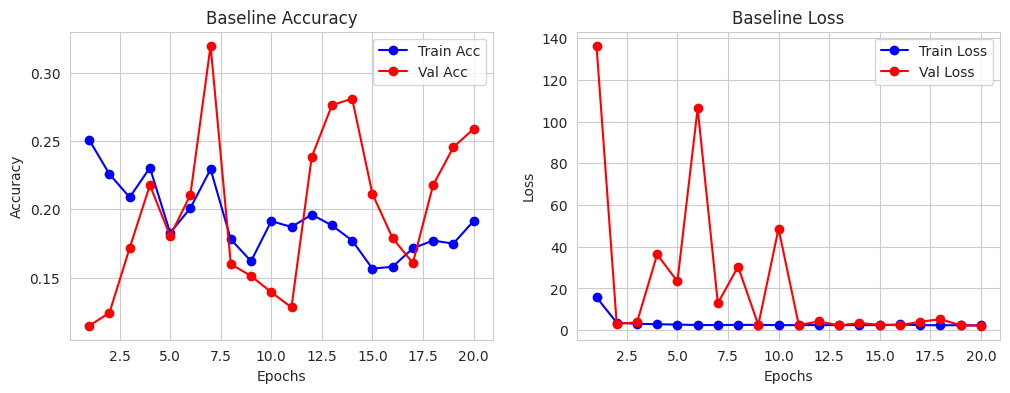

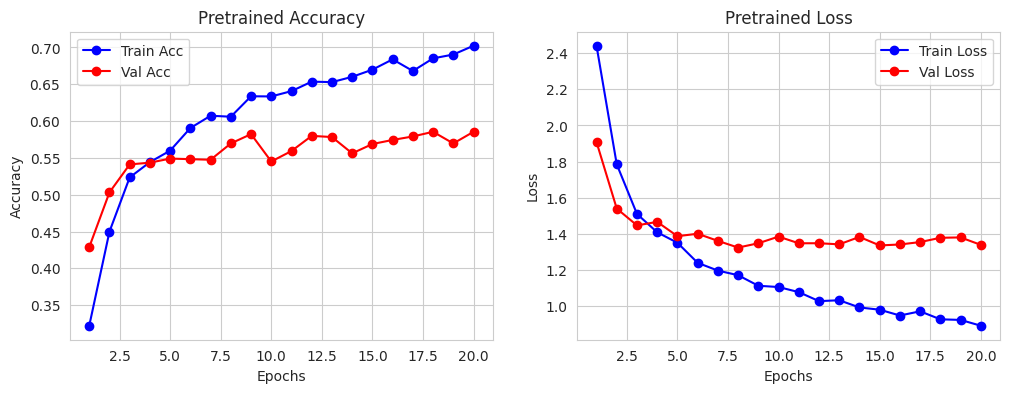

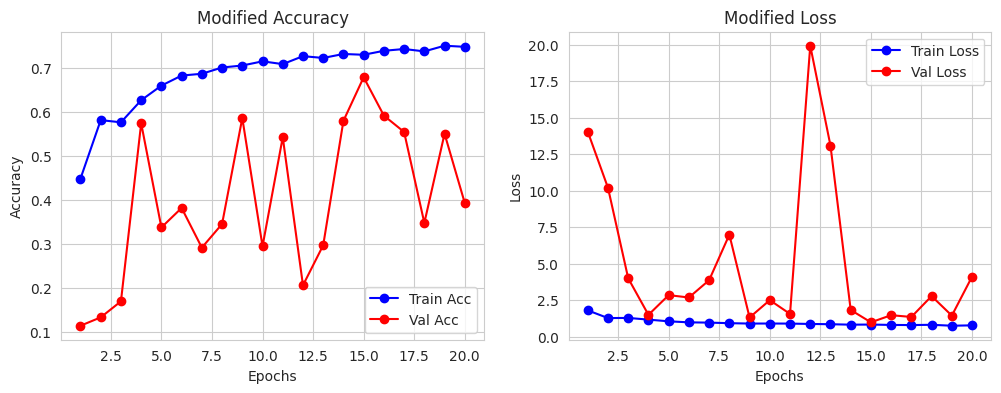

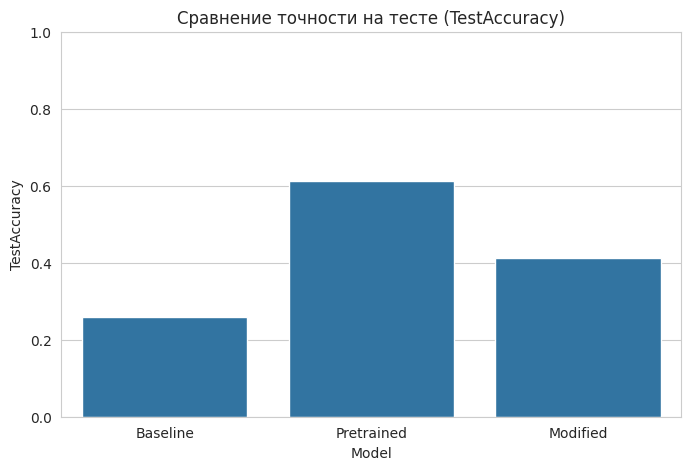

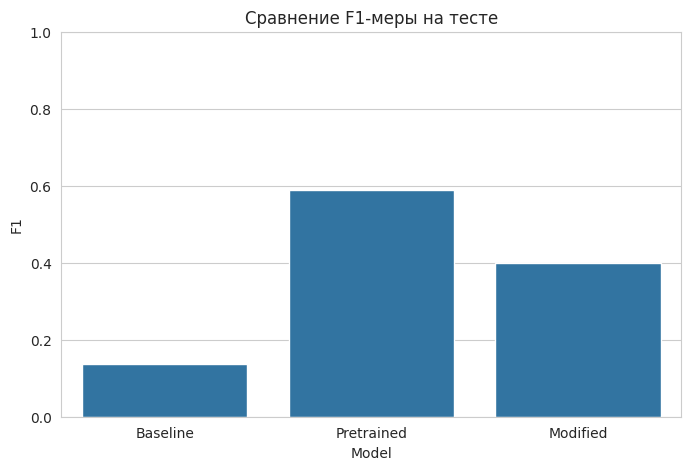

In [16]:
def plot_training_history(hist, label):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc)+1)

    # Строим на отдельных подграфах
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo-', label='Train Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
    plt.title(f"{label} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
    plt.title(f"{label} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Отобразим для каждой модели
plot_training_history(history_dict['Baseline'], "Baseline")
plot_training_history(history_dict['Pretrained'], "Pretrained")
plot_training_history(history_dict['Modified'], "Modified")

# Теперь построим общий барплот сравнения TestAccuracy (или F1)
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='TestAccuracy')
plt.title("Сравнение точности на тесте (TestAccuracy)")
plt.ylim([0, 1])
plt.show()

# Аналогично можно построить сравнение F1
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='F1')
plt.title("Сравнение F1-меры на тесте")
plt.ylim([0, 1])
plt.show()

In [17]:
# Сохранение модели в файл .h5
modified_model.save('modified_model.h5')
print("Модель сохранена в файл modified_model.h5")

Модель сохранена в файл modified_model.h5
